###  Installation de l'environnement

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



### Connexion à la DB DuckDB

In [4]:
DB_NAME = "amazing.duckdb"
TABLE_EVENTS = "all_events"
TABLE_SEGMENTS = "user_segments"
SAMPLE_USER_PERCENT = 0.005
BATCH_SIZE = 1000 

con = duckdb.connect(DB_NAME)

IOException: IO Error: Could not set lock on file "/home/c-enjalbert/Documents/EPSI/MSPR/bloc_2/amazing/amazing.duckdb": Conflicting lock is held in /home/c-enjalbert/miniconda3/bin/python3.12 (PID 10251) by user c-enjalbert. See also https://duckdb.org/docs/connect/concurrency

### Import de la table DuckDB

In [ ]:
# Chargement de users avec au moins 10 événements 
print("Chargement d'un échantillon d'utilisateurs actifs...")

# Afficher les tables disponibles dans la base de données
tables_df = con.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'main'").fetch_df()
print("Tables disponibles dans la base de données :")
print(tables_df)

user_ids_df = con.execute(f"""
    SELECT user_id
    FROM all_events
    WHERE user_id IS NOT NULL
    GROUP BY user_id
    HAVING COUNT(*) >= 10
""").fetch_df()

Chargement d'un échantillon d'utilisateurs actifs...


NameError: name 'con' is not defined

### Normalisation et Standardisation des données

In [ ]:


sampled_user_ids = user_ids_df.sample(frac=SAMPLE_USER_PERCENT, random_state=42)['user_id'].tolist()

print(f"Nombre d'utilisateurs actifs échantillonnés : {len(sampled_user_ids)}")

#  Création des features utilisateurs batch par batch 
print("Création des features utilisateurs par batch...")

user_features_list = []

for i in tqdm(range(0, len(sampled_user_ids), BATCH_SIZE), desc="Avancement user features", ncols=100):
    batch_ids = sampled_user_ids[i:i+BATCH_SIZE]
    batch_ids_str = ",".join(f"'{uid}'" for uid in batch_ids)

    batch_query = f"""
    WITH
        base_events AS (
            SELECT
                user_id,
                event_type,
                event_time,
                price,
                LEAD(event_time) OVER (PARTITION BY user_id ORDER BY event_time) AS next_event_time
            FROM {TABLE_EVENTS}
            WHERE user_id IN ({batch_ids_str})
        ),
        features AS (
            SELECT
                user_id,
                COUNT(*) AS total_events,
                SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS total_views,
                SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS total_purchases,
                AVG(EXTRACT(EPOCH FROM (next_event_time - event_time))) AS avg_time_between_events,
                SUM(CASE WHEN event_type = 'purchase' THEN price ELSE 0 END) AS total_spent,
                COALESCE(AVG(CASE WHEN event_type = 'purchase' THEN price ELSE NULL END), 0) AS avg_basket,
                MAX(event_time) AS last_event_time
            FROM base_events
            GROUP BY user_id
    )
    SELECT
        *,
        CASE WHEN total_views > 0 THEN total_purchases * 1.0 / total_views ELSE 0 END AS conversion_rate,
        CASE WHEN (total_views + total_purchases) > 0 THEN total_purchases * 1.0 / (total_views + total_purchases) ELSE 0 END AS purchase_ratio,
        DATE_PART('day', CURRENT_TIMESTAMP - last_event_time) AS days_since_last_event
    FROM features
    """

    batch_features = con.execute(batch_query).fetch_df()

    # Récupérer les user_id de cette batch
    valid_user_ids = con.execute(f"""
        SELECT user_id
        FROM {TABLE_EVENTS}
        WHERE user_id IN ({batch_ids_str})
        GROUP BY user_id
        HAVING COUNT(*) >= 10
    """).fetch_df()
    valid_user_ids = set(valid_user_ids["user_id"].astype(str))

    # Filtrage strict des user_id valides
    batch_features = batch_features[batch_features["user_id"].astype(str).isin(valid_user_ids)]

    user_features_list.append(batch_features)

# Fusionner tous les batchs
user_features = pd.concat(user_features_list, ignore_index=True)

# Vérification des NaN
print("Vérification des NaN")
nan_summary = user_features.isna().sum()
print("Résumé des NaN par colonne :")
print(nan_summary[nan_summary > 0])

users_with_nan = user_features[user_features.isna().any(axis=1)]
print(f"Nombre d'utilisateurs avec des NaN : {len(users_with_nan)}")
print("Exemples d'utilisateurs avec NaN :")
print(users_with_nan.head(10))

# Standardisation
print("Standardisation des features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features.drop(columns=["last_event_time"]))



Chargement d'un échantillon d'utilisateurs actifs...
Tables disponibles dans la base de données :
      table_name
0     all_events
1   loaded_files
2  user_segments
Nombre d'utilisateurs actifs échantillonnés : 4859
Création des features utilisateurs par batch...


Avancement user features: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]

Vérification des NaN
Résumé des NaN par colonne :
Series([], dtype: int64)
Nombre d'utilisateurs avec des NaN : 0
Exemples d'utilisateurs avec NaN :
Empty DataFrame
Columns: [user_id, total_events, total_views, total_purchases, avg_time_between_events, total_spent, avg_basket, last_event_time, conversion_rate, purchase_ratio, days_since_last_event]
Index: []
Standardisation des features...


### Fit et Analyse du Coude

Analyse du coude pour déterminer le nombre optimal de clusters...


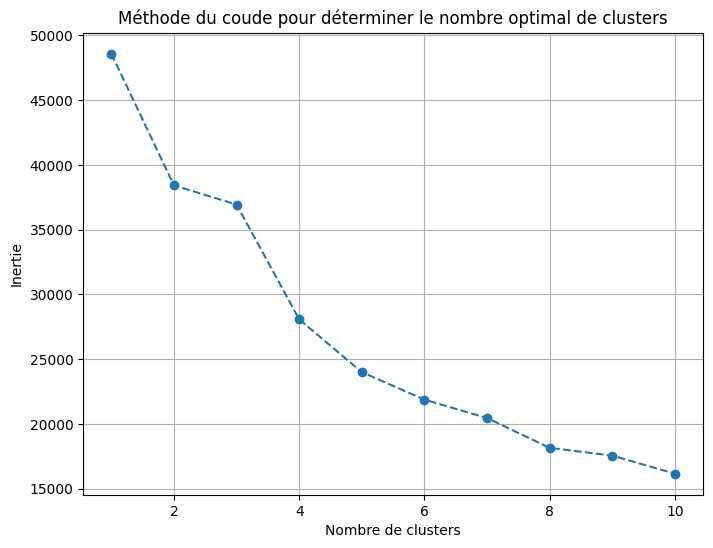

In [ ]:
# Analyse du Coude (Elbow Method)
print("Analyse du coude pour déterminer le nombre optimal de clusters...")

inertia = []
cluster_range = range(1, 11)  # Test cluster counts from 1 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()

### Analyse Silhouette, Calinski-Harabasz & Davies-Bouldin

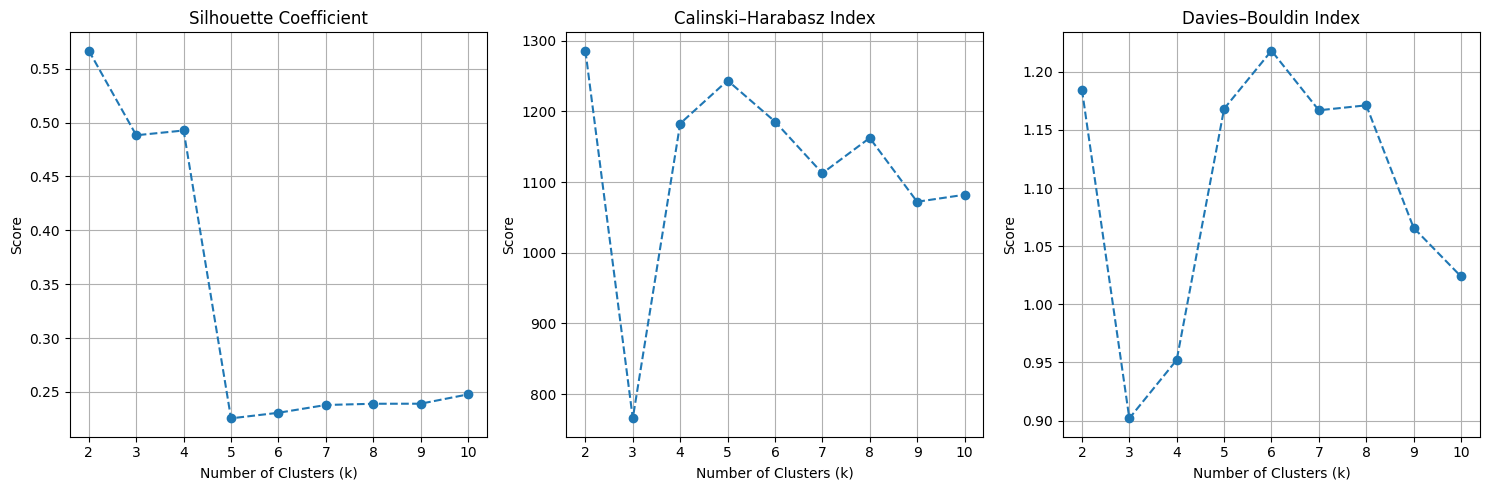

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
ks = range(2, 11)

# Initialize lists to store the scores
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Evaluate clustering for each k
for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    labels = km.labels_
    
    # Compute the metrics
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

# Plot the metrics
plt.figure(figsize=(15, 5))

# Silhouette Coefficient
plt.subplot(1, 3, 1)
plt.plot(ks, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Coefficient")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

# Calinski–Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(ks, calinski_harabasz_scores, marker='o', linestyle='--')
plt.title("Calinski–Harabasz Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

# Davies–Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(ks, davies_bouldin_scores, marker='o', linestyle='--')
plt.title("Davies–Bouldin Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

plt.tight_layout()
plt.show()

### Fit et Plot KMeans pour 4, 5 et 6 Clusters

Clustering avec KMeans...
Sauvegarde dans user_segments...
Clustering sauvegarder avec succès !
Visualisation du clustering...


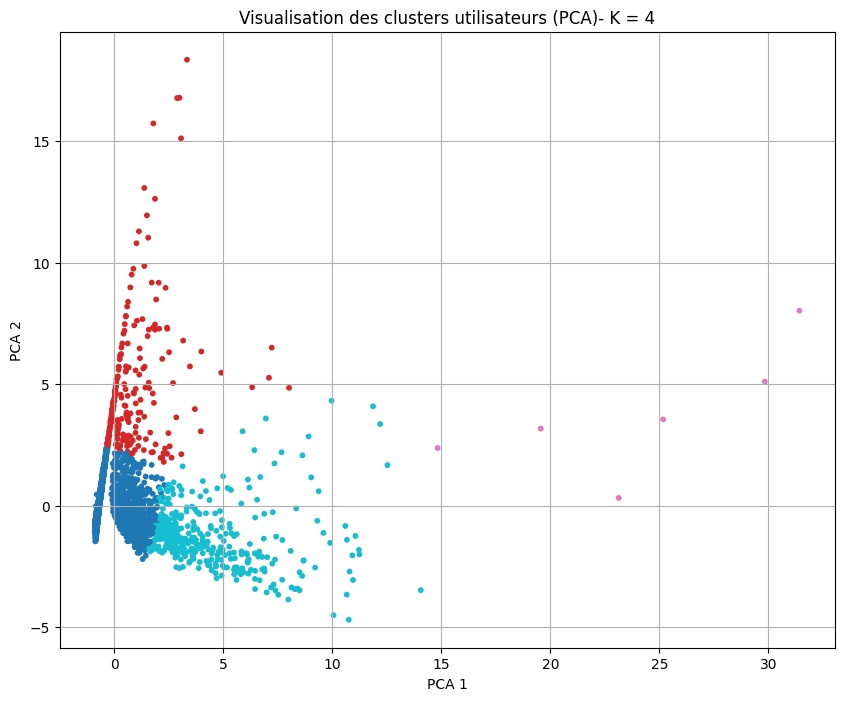

In [ ]:
N_CLUSTERS = 4
# Clustering
print("Clustering avec KMeans...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

user_features["segment"] = clusters

#  Sauvegarde des résultats dans DuckDB
print(f"Sauvegarde dans {TABLE_SEGMENTS}...")
con.execute(f"DROP TABLE IF EXISTS {TABLE_SEGMENTS}")
con.register("temp_user_features", user_features)
con.execute(f"CREATE TABLE {TABLE_SEGMENTS} AS SELECT * FROM temp_user_features")


print("Clustering sauvegarder avec succès !")


# --- Visualisation du clustering ---
print("Visualisation du clustering...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_features["segment"], cmap='tab10', s=10)
plt.title(f"Visualisation des clusters utilisateurs (PCA)- K = {N_CLUSTERS}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


Clustering avec KMeans...
Sauvegarde dans user_segments...
Clustering sauvegarder avec succès !
Visualisation du clustering...


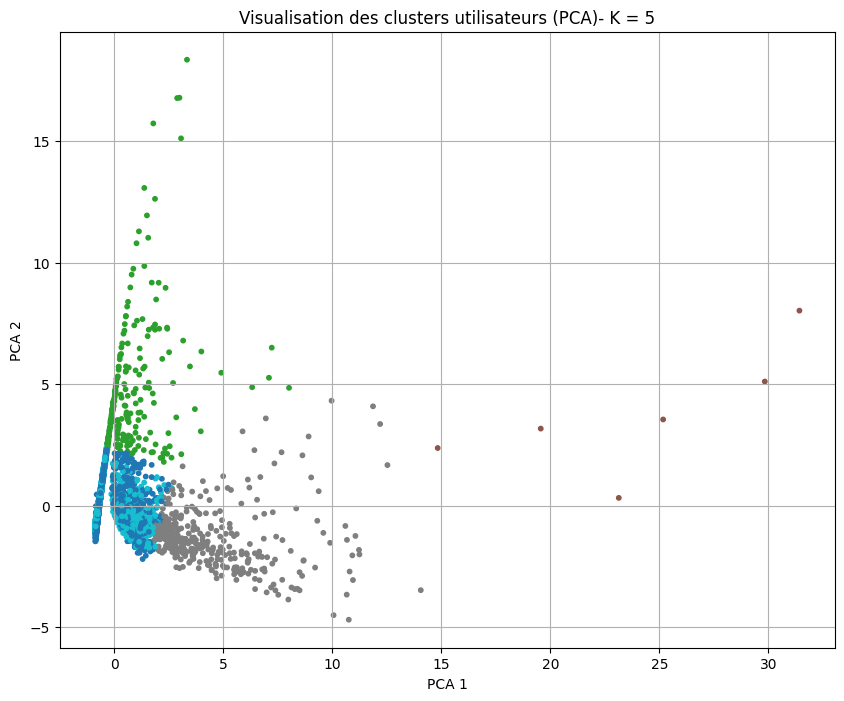

In [ ]:
N_CLUSTERS = 5
# Clustering
print("Clustering avec KMeans...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

user_features["segment"] = clusters

#  Sauvegarde des résultats dans DuckDB
print(f"Sauvegarde dans {TABLE_SEGMENTS}...")
con.execute(f"DROP TABLE IF EXISTS {TABLE_SEGMENTS}")
con.register("temp_user_features", user_features)
con.execute(f"CREATE TABLE {TABLE_SEGMENTS} AS SELECT * FROM temp_user_features")


print("Clustering sauvegarder avec succès !")


# --- Visualisation du clustering ---
print("Visualisation du clustering...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_features["segment"], cmap='tab10', s=10)
plt.title(f"Visualisation des clusters utilisateurs (PCA)- K = {N_CLUSTERS}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

Clustering avec KMeans...
Sauvegarde dans user_segments...
Clustering sauvegarder avec succès !
Visualisation du clustering...


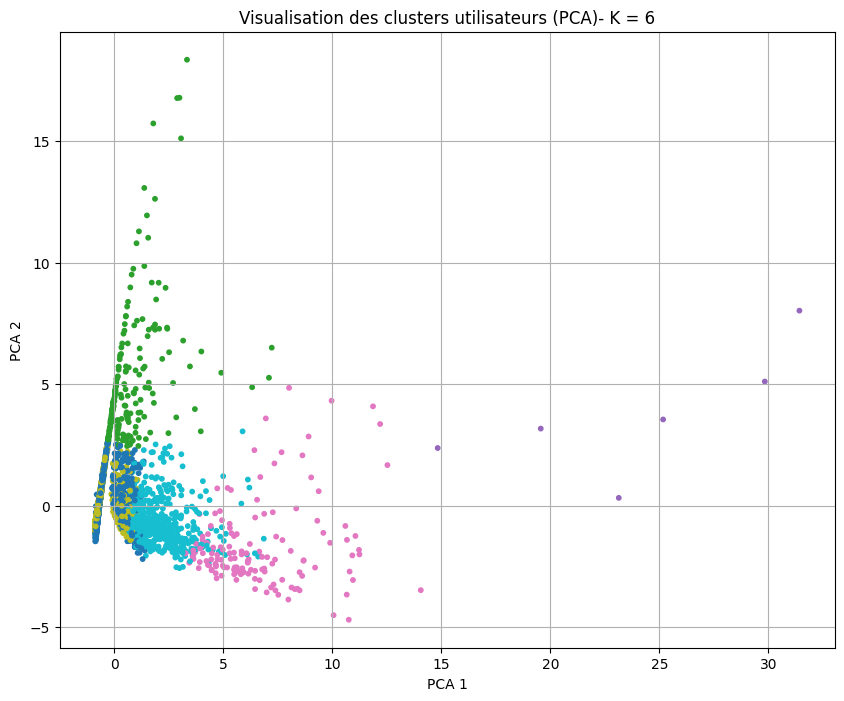

In [ ]:
N_CLUSTERS = 6
# Clustering
print("Clustering avec KMeans...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

user_features["segment"] = clusters

#  Sauvegarde des résultats dans DuckDB
print(f"Sauvegarde dans {TABLE_SEGMENTS}...")
con.execute(f"DROP TABLE IF EXISTS {TABLE_SEGMENTS}")
con.register("temp_user_features", user_features)
con.execute(f"CREATE TABLE {TABLE_SEGMENTS} AS SELECT * FROM temp_user_features")


print("Clustering sauvegarder avec succès !")


# --- Visualisation du clustering ---
print("Visualisation du clustering...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_features["segment"], cmap='tab10', s=10)
plt.title(f"Visualisation des clusters utilisateurs (PCA)- K = {N_CLUSTERS}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

### Sauvegarde du DataFrame en Table DuckDB

In [ ]:
# Lister toutes les tables et colonnes des tables
print("Tables disponibles dans la base :")
tables = con.execute("SHOW TABLES").fetch_df()
print(tables)

print("Structure de la table all_events :")
schema_all_events = con.execute("DESCRIBE TABLE all_events").fetch_df()
print(schema_all_events)

print("Structure de la table user_segments :")
schema_user_segments = con.execute("DESCRIBE TABLE user_segments").fetch_df()
print(schema_user_segments)

df_purchase = con.execute("SELECT * FROM user_segments LIMIT 10").fetch_df()
print(df_purchase)

Tables disponibles dans la base :
                 name
0          all_events
1        loaded_files
2  temp_user_features
3       user_segments
Structure de la table all_events :
     column_name column_type null   key default extra
0     event_time   TIMESTAMP  YES  None    None  None
1     event_type     VARCHAR  YES  None    None  None
2     product_id     VARCHAR  YES  None    None  None
3    category_id     VARCHAR  YES  None    None  None
4  category_code     VARCHAR  YES  None    None  None
5          brand     VARCHAR  YES  None    None  None
6          price      DOUBLE  YES  None    None  None
7        user_id     VARCHAR  YES  None    None  None
8   user_session     VARCHAR  YES  None    None  None
Structure de la table user_segments :
                column_name column_type null   key default extra
0                   user_id     VARCHAR  YES  None    None  None
1              total_events      BIGINT  YES  None    None  None
2               total_views      DOUBLE  YES  No

In [ ]:
# Fermeture de la connexion DuckDB
con.close()